In [6]:
import cv2 as cv
import imageio.v3 as imageio
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

In [7]:
path1 = "img/gray_l.png"
path2 = "img/gray_h.png"

src_img = cv.imread(path1)
dst_img = cv.imread(path2)

if src_img is None or dst_img is None:
    print("ERROR")
    
src_img = cv.cvtColor(src_img, cv.COLOR_BGR2GRAY)
dst_img = cv.cvtColor(dst_img, cv.COLOR_BGR2GRAY)

In [8]:
#src_img = cv.equalizeHist(src_img)
#dst_img = cv.equalizeHist(dst_img)

# histogramas com as normalizações
src_hist = cv.calcHist([src_img], [0], None, [256], [0, 256])
dst_hist = cv.calcHist([dst_img], [0], None, [256], [0, 256])

src_hist_norm = src_hist / src_img.size
dst_hist_norm = dst_hist / dst_img.size

# CDFs dos histogramas (PDF)
src_cdf = src_hist_norm.cumsum()
dst_cdf = dst_hist_norm.cumsum()

# Interpolação dos valores da função de transferencia
lut = np.interp(src_cdf, dst_cdf, np.arange(256))

matched_img = cv.LUT(src_img, lut.astype(np.uint8))
 
mat_hist = cv.calcHist([matched_img], [0], None, [256], [0, 256])
mat_hist_norm = mat_hist/mat_hist.size
mat_cdf = mat_hist_norm.cumsum();


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


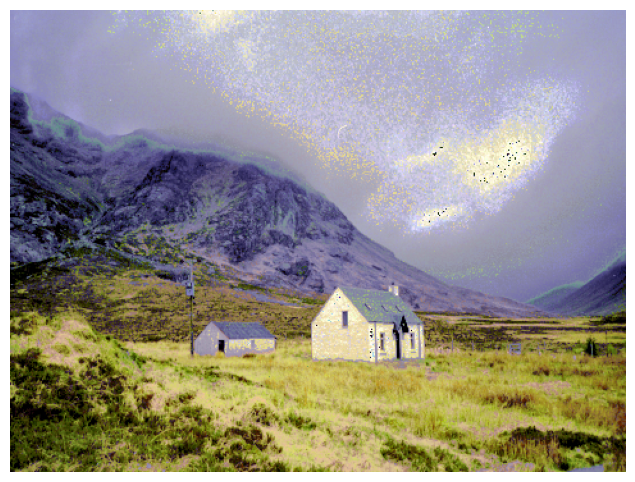

In [9]:
def colour_transfer_idt(i0, i1, bins=300, n_rot=10, relaxation=1):
    n_dims = i0.shape[1]
    
    d0 = i0.T
    d1 = i1.T
    
    for i in range(n_rot):
        
        r = sp.stats.special_ortho_group.rvs(n_dims).astype(np.float32)
        
        d0r = np.dot(r, d0)
        d1r = np.dot(r, d1)
        d_r = np.empty_like(d0)
        
        # 3 dims
        for j in range(n_dims):
            
            lo = min(d0r[j].min(), d1r[j].min())
            hi = max(d0r[j].max(), d1r[j].max())
            
            
            p0r, edges = np.histogram(d0r[j], bins=bins, range=[lo, hi])
            p1r, _     = np.histogram(d1r[j], bins=bins, range=[lo, hi])

            cp0r = p0r.cumsum().astype(np.float32)
            cp0r /= cp0r[-1]

            cp1r = p1r.cumsum().astype(np.float32)
            cp1r /= cp1r[-1]
            
            f = np.interp(cp0r, cp1r, edges[1:])
            
            d_r[j] = np.interp(d0r[j], edges[1:], f, left=0, right=bins)
        
        d0 = relaxation * np.linalg.solve(r, (d_r - d0r)) + d0
    
    return d0.T

path1 = "img/inpt.png"
path2 = "img/refer.png"

im_orig = plt.imread(path1)
im_target = plt.imread(path2)

df_orig = pd.DataFrame(im_orig.reshape(-1, im_orig.shape[-1]), columns=['r', 'g', 'b'])
df_target = pd.DataFrame(im_target.reshape(-1, im_target.shape[-1]), columns=['r', 'g', 'b'])

a_orig = df_orig.values
a_target = df_target.values

np.random.seed(42)
bins = 100

a_result = colour_transfer_idt(a_orig, a_target, bins=300, n_rot=20, relaxation=1)

df_result = pd.DataFrame(a_result, columns=['r', 'g', 'b'])
im_result = a_result.reshape(im_orig.shape)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(im_result)
ax.axis('off')

plt.show()


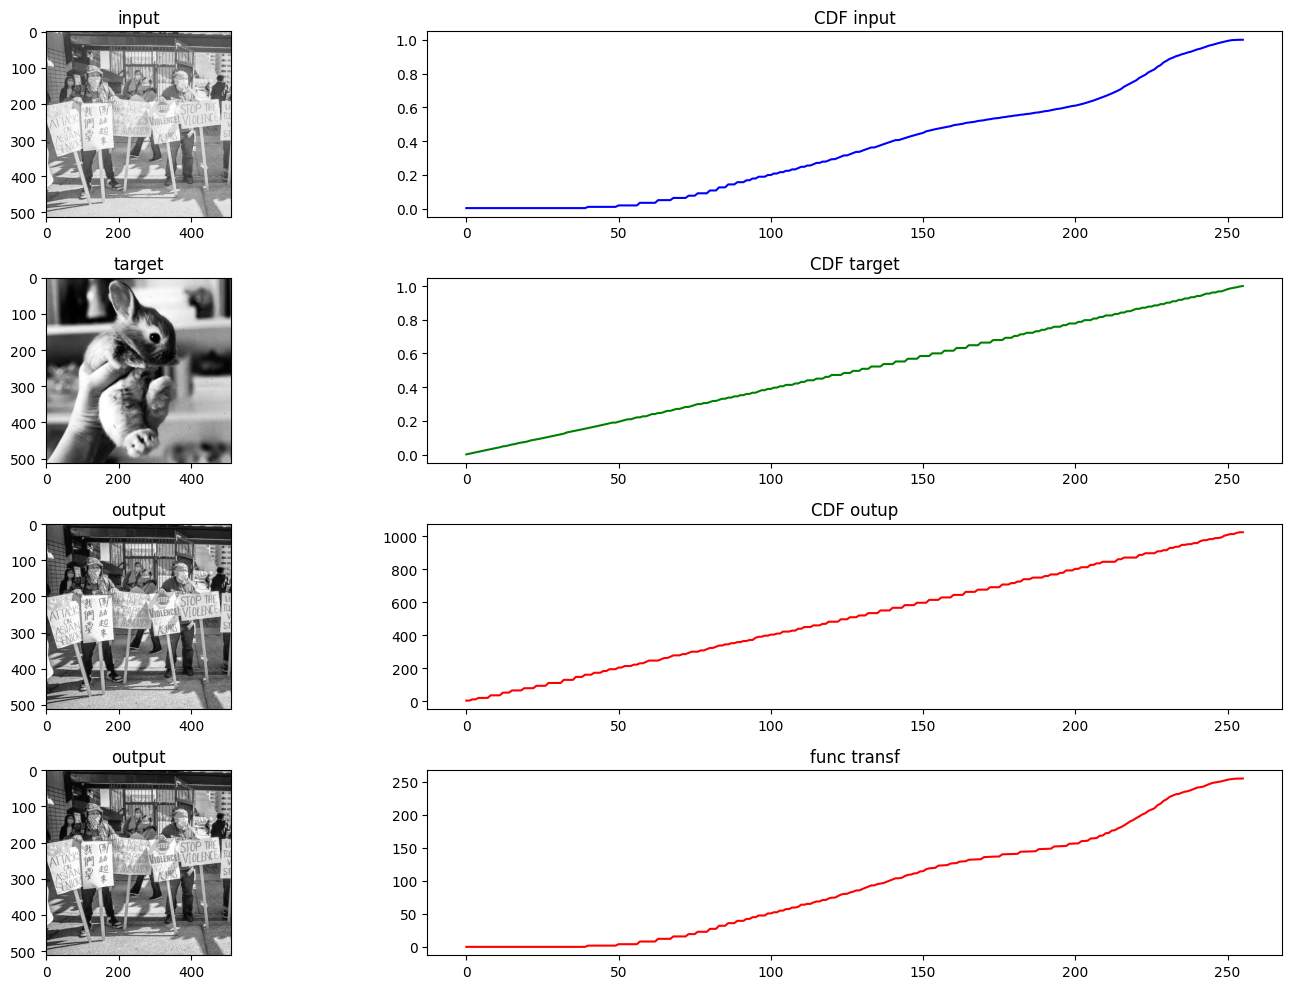

In [10]:
plt.figure(figsize=(16, 10))

plt.subplot(4, 2, 1)
plt.imshow(src_img, cmap='gray')
plt.title('input')

plt.subplot(4, 2, 2)
plt.plot(src_cdf, color='blue')
plt.title('CDF input')

plt.subplot(4, 2, 3)
plt.imshow(dst_img, cmap='gray')
plt.title('target')

plt.subplot(4, 2, 4)
plt.plot(dst_cdf, color='green')
plt.title('CDF target')

plt.subplot(4, 2, 5)
plt.imshow(matched_img, cmap='gray')
plt.title('output')

plt.subplot(4, 2, 6)
plt.plot(mat_cdf, color='red')
plt.title('CDF outup')

plt.subplot(4, 2, 7)
plt.imshow(matched_img, cmap='gray')
plt.title('output')

plt.subplot(4, 2, 8)
plt.plot(lut, color='red')
plt.title('func transf')

plt.tight_layout()
plt.show()